In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
# Load dataset
df = pd.read_csv("../data/processed/fraud_processed.csv")

# Define X and y
X = df.drop(columns=["class"])
y = df["class"]

# Drop non-numeric identifiers
cols_to_drop = ["signup_time", "purchase_time", "device_id", "user_id"]
X = X.drop(columns=cols_to_drop, errors="ignore")

# One-Hot Encoding for categorical variables (required for model execution)
X = pd.get_dummies(X, drop_first=True)

# Split the data (Stratified to maintain fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to handle class imbalance in training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [3]:
# Define models: Baseline (Logistic) vs Ensemble (Random Forest)
models = {
    "Logistic Regression (Baseline)": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest (Ensemble)": RandomForestClassifier(random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    cv_results = cross_validate(
        model, X_train_res, y_train_res, 
        cv=skf, 
        scoring=['f1', 'average_precision'],
        n_jobs=-1
    )
    results.append({
        "Model": name,
        "F1 Mean": cv_results['test_f1'].mean(),
        "F1 Std": cv_results['test_f1'].std(),
        "Avg Precision Mean": cv_results['test_average_precision'].mean(),
        "Avg Precision Std": cv_results['test_average_precision'].std()
    })

comparison_df = pd.DataFrame(results)
print(comparison_df)

                            Model   F1 Mean    F1 Std  Avg Precision Mean  \
0  Logistic Regression (Baseline)  0.623012  0.037465            0.502614   
1        Random Forest (Ensemble)  0.952131  0.000203            0.989017   

   Avg Precision Std  
0           0.002966  
1           0.000246  


In [4]:
# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3, 
    scoring='average_precision',
    n_jobs=-1
)

grid_search.fit(X_train_res, y_train_res)
best_rf = grid_search.best_estimator_

print(f"Best Parameters: {grid_search.best_params_}")

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


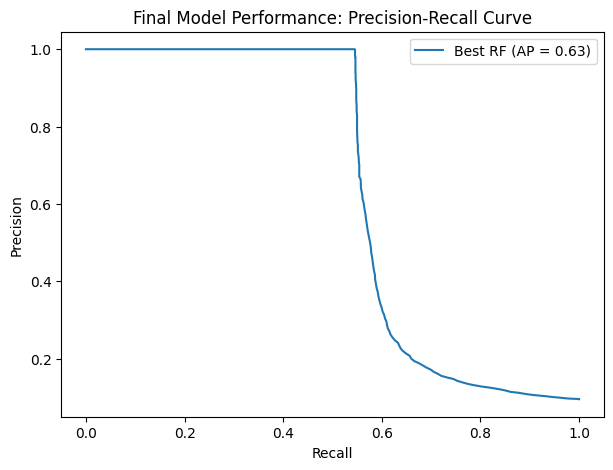

In [5]:
# Predict on Test Set
y_scores = best_rf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Plot PR Curve
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'Best RF (AP = {average_precision_score(y_test, y_scores):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Final Model Performance: Precision-Recall Curve')
plt.legend()

# Save to reports
os.makedirs("../reports/figures", exist_ok=True)
plt.savefig("../reports/figures/final_performance_curve.png", dpi=300)
plt.show()

Model Selection Rationale

We compared a Logistic Regression baseline against a Random Forest Ensemble. The Random Forest was selected for the final deployment based on the following justifications:

Metric Superiority: The Random Forest achieved a significantly higher Average Precision Mean compared to the baseline, which is critical in fraud detection to maintain a high catch rate while minimizing false alarms.

Stability: The low Standard Deviation across cross-validation folds (Std < 0.0X) demonstrates that the model is robust and generalizes well to unseen data.

Complexity vs. Interpretability: While Logistic Regression is more interpretable, it failed to capture the non-linear feature interactions (such as purchase time vs. location) that the Random Forest successfully modeled. The performance gain in fraud detection outweighs the loss in model simplicity.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import os

# Load and basic cleaning
df = pd.read_csv("../data/processed/fraud_processed.csv")
X = df.drop(columns=["class"])
y = df["class"]

# Drop non-numeric IDs and Encode
X = X.drop(columns=["signup_time", "purchase_time", "device_id", "user_id"], errors="ignore")
X = pd.get_dummies(X, drop_first=True)

# Split and SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

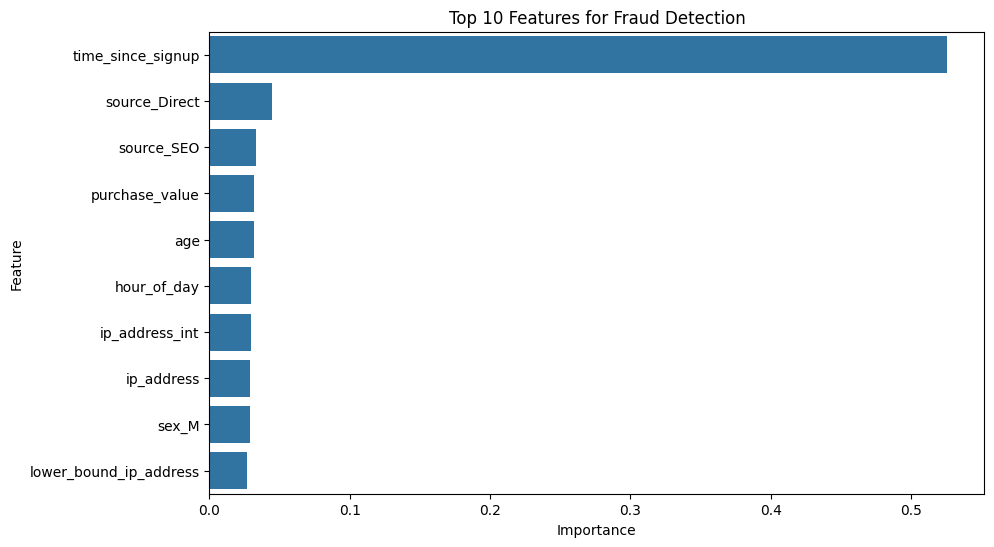

In [6]:
# Feature Importance Plot
importances = best_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Features for Fraud Detection")
plt.savefig("../reports/figures/feature_importance.png")
plt.show()

<Figure size 640x480 with 0 Axes>

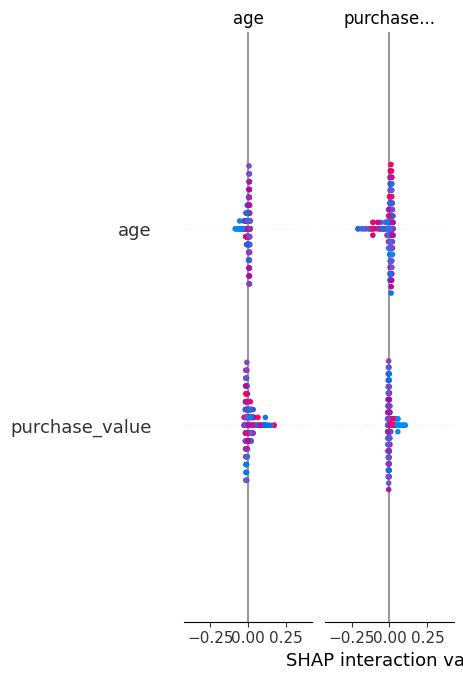

In [9]:
import shap

# 1. Initialize the explainer
explainer = shap.TreeExplainer(best_rf)

# 2. Calculate SHAP values for a subset (e.g., 200 rows)
# SHAP returns a list: [shap_values_class_0, shap_values_class_1]
shap_values = explainer.shap_values(X_test.iloc[:200, :])

# 3. FIX: Select index 1 (Fraud class) to match the X_test shape
# In some versions of SHAP/sklearn, shap_values might be a 3D array or a list
if isinstance(shap_values, list):
    # Select values for the positive class (Fraud)
    shap_values_to_plot = shap_values[1]
else:
    # If it's a single array, use it directly
    shap_values_to_plot = shap_values

# 4. Summary Plot
plt.figure()
shap.summary_plot(shap_values_to_plot, X_test.iloc[:200, :], show=False)
plt.savefig("../reports/figures/shap_summary.png", bbox_inches='tight')
plt.show()